<a href="https://www.kaggle.com/code/dascient/3-simple-moving-averages-performance-testing?scriptVersionId=215626952" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Hello, world!
[Read our blog about how & why this notebook was written.](https://medium.com/coinmonks/3-simple-moving-averages-trade-strategy-performance-test-2194f423d36b?source=user_profile---------1----------------------------)

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from IPython.display import clear_output
from dateutil.tz import tzlocal
import matplotlib.pyplot as plt
from datetime import datetime
!pip install pandas_ta
import pandas_ta as ta # https://github.com/twopirllc/pandas-ta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time 

import warnings # feel free to remove these
warnings.filterwarnings('ignore')

# performance metrics package
# https://vectorbt.dev
!pip install vectorbt==0.20.1
import vectorbt as vbt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

clear_output()

In [6]:
# Three Moving Averages Strategy + VectorBT's Performance Metrics Package
## For backtesting combinations of three simple moving averages

Upload a couple of historical cryptocurrency data. 

Text(0.5, 1.0, '(Not-so) MOST RECENT LIVE BTC Chart')

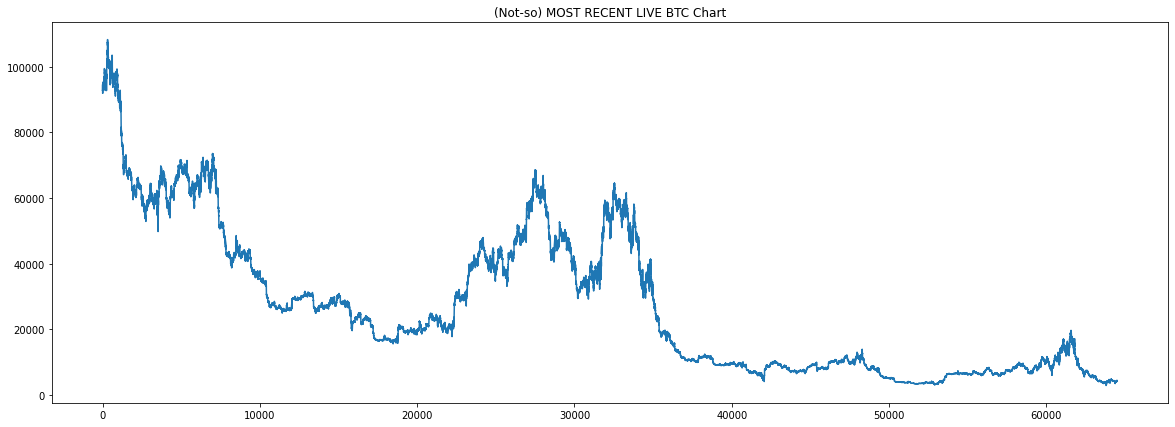

In [50]:
btc = pd.read_csv('../input/top-8-crypto-currency-data/BTC-EUR.csv')
eth = pd.read_csv('../input/top-8-crypto-currency-data/ETH-EUR.csv')

# live
btc_live = pd.read_csv('https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_1h.csv',header=1)

btc_live['Close'].plot(figsize=(20,7))
plt.title("(Not-so) MOST RECENT LIVE BTC Chart")

Text(0.5, 1.0, 'ETH Chart')

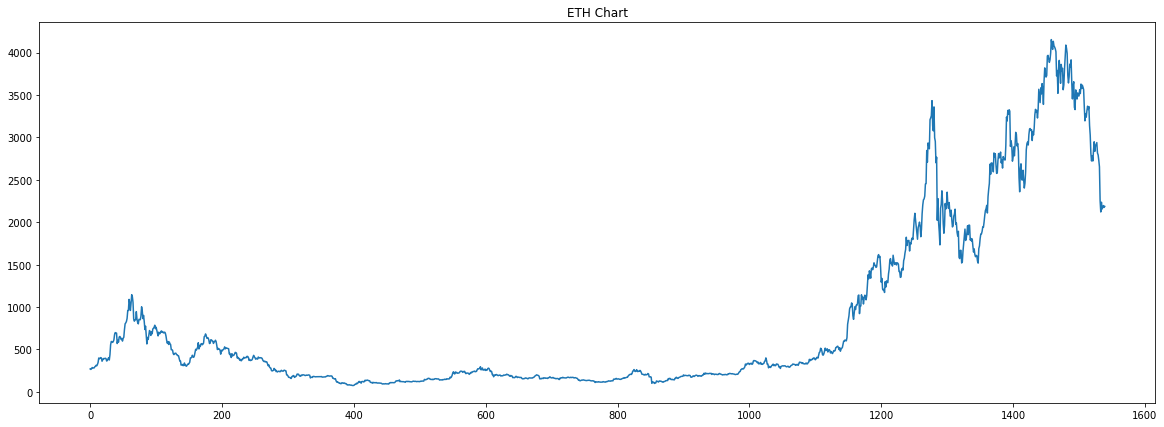

In [49]:
# historical
eth.Close.plot(figsize=(20,7))
plt.title("ETH Chart")

Pandas_TA has a tsignals function that allows us to set boolean entities as our "entry" & "exit" signals. You might find the algorithm below to be a bit strange, but my goal was to try and determine the best Three-Moving-Averages sma combinations. I thought it would be interesting to reiterate through the multiplicative combinations of trading against thee (3) simple moving averages.

In [51]:
# https://github.com/twopirllc/pandas-ta#performance-metrics

# define True/False signal parameters for 3 SMAs
def tsignals(df,a,b,c):
    # Create the "Golden Cross" conditions
    # three simple moving average with their periods set as variables
    smaA = df.ta.sma(a, append=True)
    smaB = df.ta.sma(b, append=True)
    smaC = df.ta.sma(c, append=True)
    close = df.Close[len(df)-1]
    
    # when the smaA cross above smaB and smaC, we give a "True" signal for entries
    # IMPORTANT part of assumed straegy
    
    #df["GC"] = (smaA > smaB) & (smaB > smaC)
    df["GC"] = (close > smaA) & (smaA > smaB) & (smaB > smaC)
    
    
    golden = df.ta.tsignals(df.GC, asbool=True, append=True)

    # Create the Signals Portfolio Performance Assessment report
    pf = vbt.Portfolio.from_signals(df.Close, entries=golden.TS_Entries, exits=golden.TS_Exits, freq="D", 
                                    # set initial principal and other params, docs fuond in vectorbt
                                    init_cash=100, fees=0.0025, slippage=0.0025)


    # values from report we care about
    ev = pf.stats()['End Value']
    re = pf.stats()['Total Return [%]']
    
    return pd.Series([ev,re,a,b,c]),df,pf,golden

In [11]:
# range of curious movAvg values & initialize results frame

# after many trials, I decided the best ranges for a,b,c are as follows:
sma_a, sma_b, sma_c, results = list(range(7,40)),list(range(41,120)),list(range(121,135)),[]

# for the sake of computation efficiency...
#df = eth
df = btc_live

# re(re(iteration))
# this will take a while to run, 
# it evaluates profit/loss outcomes
# by trying each sma(a,b,c) combinations.

thresh = 0#15 # hoping to display only results that yield above 15% profit
for c in sma_c:
    for b in sma_b:
        for a in sma_a:
            if tsignals(df,a,b,c)[0][1] > thresh:

                try:
                    print(f"\n*Testing: sma_{a}, sma_{b}, sma_{c}*\n")
                    print(f"*Score: {tsignals(df,a,b,c)[0][1]}*\n")
                    results.append(tsignals(df,a,b,c)[0])
                    clear_output()
                except:
                    print(f"No results yielding over {thresh}.")

res = pd.DataFrame(results)
best_res = res.sort_values(res.columns[1],ascending=False).head(3).reset_index(drop=True)
print("Best resolution:\nEnd Principal, % Return, SMAa, SMAb, SMAc")
print(best_res)

[X] Ooops!!! It's True, the series 'close' was not found in https://www.CryptoDataDownload.com
[X] Ooops!!! It's True, the series 'close' was not found in https://www.CryptoDataDownload.com
[X] Ooops!!! It's True, the series 'close' was not found in https://www.CryptoDataDownload.com


AttributeError: 'DataFrame' object has no attribute 'Close'

In [ ]:
# highest yielding sma_value
a = best_res[2][0]
b = best_res[3][0]
c = best_res[4][0]
print(f"\nBest SMA Throuple: {a}, {b}, {c}")
print(f"Number of results evaluated: {len(results)}")

########################################################

# le winner
df, pf = tsignals(df,a,b,c)[1], tsignals(df,a,b,c)[2].stats()
golden = tsignals(df,a,b,c)[3]
# params
fig, ax = plt.subplots(figsize=(20, 8))

# plot
ax.plot(df.Close, color = 'black', label = 'closePrice')
ax.plot(df.ta.sma(a), color = 'orange', label = f'sma-{a}')
ax.plot(df.ta.sma(b), color = 'red', label = f'sma-{b}')
ax.plot(df.ta.sma(c), color = 'purple', label = f'sma-{c}')

# signals
xcoords_buy, xcoords_sell = golden[golden.TS_Entries == True].index, golden[golden.TS_Exits == True].index

for xc in xcoords_sell:
    plt.axvline(x=xc,c='r')
for xc in xcoords_buy:
    plt.axvline(x=xc,c='g')

# plot outputs
ax.legend(loc = 'upper left')
plt.show()

In [ ]:
# not very definitive of the absolute BEST combination. but it does yield some pretty neat outputs.